<a href="https://colab.research.google.com/github/danmenloz/CropDamage/blob/master/Segnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <strong>Vanilla VAE</strong>

Basic Variational Autoencoder for the MNIST dataset

# Importing Libraries

In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob, os
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
from PIL import Image

# Main Parameters

In [ ]:
# Dataset
train_p = 70 # Percentage of images for training
valid_p = 15 # Percentage of images for validation
test_p = 15 # Percentage images for test
batch_size = 8 # High value could impact RAM memory
img_size = (216, 288) # Image size reduction ratio 1/16
real_size = (3456, 4608) # To estimate Jaccard Score
store_in_ram = True

# Hyperparameters
num_epochs = 120
learning_rate = 0.001
use_gpu = True

# Importing Dataset

In [ ]:
#Access data in Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import ResNet Model
import sys
sys.path.append('/content/drive/My Drive/ECE_542-Project_2/Colab Notebooks')
from segnet_model import SegNet

In [ ]:
# Get timeseries dataset with 160 length and 80 overlap
X_path = "/content/drive/My Drive/ECE_542-Project_2/Data/Train"
Y_path = "/content/drive/My Drive/ECE_542-Project_2/Data/Train-Annotations"

dataX_files = np.array(glob.glob(os.path.join(X_path, "*.jpg")))
dataY_files = np.array(glob.glob(os.path.join(Y_path, "*.png")))
dataX_files = sorted(dataX_files) # Ensures one to one match between images and annotations
dataY_files = sorted(dataY_files) # Ensures one to one match between images and annotations
#test_files = np.array(glob.glob(os.path.join(path, "/Test/*.jpg")))

In [ ]:
c = 0
for i in range(len(dataX_files)):
  if dataX_files[i][:-4][-4:] == dataY_files[i][:-4][-4:]:
    c += 1
print(c)
print(len(dataX_files))

585
585


In [ ]:
# Class for reading data directly from csv file
class Image_Dataset(Dataset):
  # Characterizes a dataset for PyTorch
  def __init__(self, X_paths, Y_paths, transform=None):
    self.X_paths = X_paths
    self.Y_paths = Y_paths
    self.transform = transform
  
  def __len__(self):
    return len(self.X_paths)

  def __getitem__(self, index):
    x = Image.open(self.X_paths[index])
    y = Image.open(self.Y_paths[index])
    if self.transform:
      x = self.transform(x) #Resize
      y = self.transform(y)
    return x, y

In [ ]:
# Length for train, valid and test data
train_len = int(train_p * len(dataX_files) / 100)
valid_len = int(valid_p * len(dataX_files) / 100)
test_len = len(dataX_files) - train_len - valid_len

# Resize Image and Normalization transforms
composed = transforms.Compose([transforms.Resize(img_size, interpolation = 0), # 0: Nearest Neighbors
                               # Rotations
                               # Mirrow
                               # Increase horizontal pattern 
                               transforms.ToTensor()])

# Pytorch Dataset
dataset = Image_Dataset(dataX_files, dataY_files, transform = composed) # dataset[0] = (img(0), annotation(0))
train, valid, test = random_split(dataset, [train_len, valid_len, test_len])

# Pytorch Dataloader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = True, num_workers = 2)
valid_loader = DataLoader(valid, batch_size = batch_size, shuffle = True, num_workers = 2)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = True, num_workers = 2)

In [ ]:
dataset[0]

(tensor([[[0.1373, 0.2314, 0.1725,  ..., 0.1686, 0.1490, 0.1961],
          [0.2431, 0.1333, 0.1412,  ..., 0.1843, 0.1569, 0.1294],
          [0.2078, 0.1451, 0.1137,  ..., 0.1882, 0.2196, 0.1490],
          ...,
          [0.1922, 0.1608, 0.2667,  ..., 0.1765, 0.2078, 0.2157],
          [0.1059, 0.1647, 0.1569,  ..., 0.2000, 0.2078, 0.2235],
          [0.1725, 0.1020, 0.2706,  ..., 0.1725, 0.2039, 0.2510]],
 
         [[0.1216, 0.2235, 0.1608,  ..., 0.2431, 0.2039, 0.2706],
          [0.2275, 0.1216, 0.1216,  ..., 0.2392, 0.2118, 0.2078],
          [0.1765, 0.1373, 0.1020,  ..., 0.2431, 0.2706, 0.2275],
          ...,
          [0.1922, 0.1608, 0.2314,  ..., 0.2275, 0.2784, 0.2863],
          [0.0863, 0.1686, 0.1294,  ..., 0.2588, 0.2745, 0.3059],
          [0.1686, 0.1020, 0.2667,  ..., 0.2471, 0.2667, 0.3216]],
 
         [[0.0863, 0.1725, 0.0941,  ..., 0.1255, 0.1020, 0.1451],
          [0.1843, 0.0941, 0.0980,  ..., 0.1373, 0.1216, 0.0706],
          [0.1333, 0.0863, 0.0745,  ...,

In [ ]:
# Storing tensors in Colab RAM (Takes about 10 minutes to finish)
def save_to_tensor(data_loader):
  dataX_list = []
  dataY_list = []
  for dataX, dataY in data_loader:
    dataX_list.append(dataX)
    dataY_list.append(dataY)
  dataX_t = torch.tensor(np.vstack(dataX_list))
  dataY_t = torch.tensor(np.vstack(dataY_list))
  return dataX_t, dataY_t

if store_in_ram:
  trainX_data, trainY_data = save_to_tensor(train_loader)
  validX_data, validY_data = save_to_tensor(valid_loader)
  testX_data, testY_data = save_to_tensor(test_loader)
  train = TensorDataset(trainX_data, trainY_data)
  valid = TensorDataset(validX_data, validY_data)
  test = TensorDataset(testX_data, testY_data)
  train_loader = DataLoader(train, batch_size = batch_size, shuffle = True, num_workers=2)
  valid_loader = DataLoader(valid, batch_size = batch_size, shuffle = True, num_workers=2)
  test_loader = DataLoader(test, batch_size = batch_size, shuffle = True, num_workers=2)

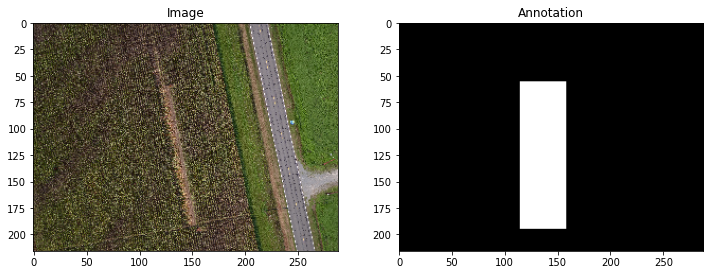

In [ ]:
# Ploting original and annotation Image
N = int(np.random.uniform(high = batch_size))
img, label = iter(train_loader).next()
f = plt.figure(figsize=(12,8))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
img = img[N,:,:,:].permute(1, 2, 0)
ax1.imshow(img, cmap = 'gray')
ax1.title.set_text('Image')
label = label[N,0,:,:]
ax2.imshow(label, cmap = 'gray')
ax2.title.set_text('Annotation')

In [ ]:
# Samples per dataset
if store_in_ram:
  print("Samples in Train: %d" % len(trainX_data))
  print("Samples in Valid: %d" % len(validX_data))
  print("Samples in Test: %d" % len(testX_data))
else:
  print("Samples in Train: %d" % len(train.indices))
  print("Samples in Valid: %d" % len(valid.indices))
  print("Samples in Test: %d" % len(test.indices))

Samples in Train: 409
Samples in Valid: 87
Samples in Test: 89


# AE Definition

## Encoder Model

In [ ]:
class Encoder(nn.Module):
  def __init__(self, channels_cnn, kernels, strides):
    super(Encoder, self).__init__()
    self.channels_cnn = channels_cnn
    self.kernels = kernels
    self.encoder = []
    
    for i in range(len(self.channels_cnn) - 1):
      chIn = self.channels_cnn[i]
      chOut = self.channels_cnn[i + 1]
      layer = nn.Conv2d(chIn, chOut, kernels[i], padding = 1, stride = strides[i]) # conv2d(3,16,(3,3),padding=1, )
      self.encoder.extend([layer, nn.ReLU()])#, maxpool_layer])
    self.encoder.pop()
    self.encoder = nn.Sequential(*self.encoder) # Stacking all layers

  def forward(self, x):
    x = self.encoder(x)
    return x

## Decoder Model

In [ ]:
class Decoder(nn.Module):
  def __init__(self, channels_cnn, kernels, strides):
    super(Decoder, self).__init__()
    self.channels_cnn = channels_cnn
    self.kernels = kernels
    self.decoder = []

    # Convolutional Layers
    for i in range(len(self.channels_cnn) - 1):
      chIn = self.channels_cnn[i]
      chOut = self.channels_cnn[i + 1]
      layer = nn.ConvTranspose2d(chIn, chOut, kernels[i], padding = 1, stride = strides[i])
      self.decoder.extend([layer,nn.ReLU()])
    self.decoder.pop() # Deletes last ReLU layer
    self.decoder.extend([nn.Sigmoid()]) # Adds sigmoid layer
    self.decoder = nn.Sequential(*self.decoder) # Stacking all layers
    

  def forward(self, x):
    x = self.decoder(x)
    #x = torch.sigmoid(self.conv1(x)) # review
    return x

## AE Model

In [ ]:
class Autoencoder(nn.Module):
  def __init__(self, in_layers, out_layers, in_kernels, out_kernels, in_strides, out_strides):
    super(Autoencoder, self).__init__()
    
    # Encoder Layer
    self.encoder = Encoder(in_layers, in_kernels, in_strides)
    
    # Decoder Layer
    self.decoder = Decoder(out_layers, out_kernels, out_strides)

  def forward(self, x):
    x_shrink = self.encoder(x)
    x_recon = self.decoder(x_shrink)
    return x_recon, x_shrink

## Loss Function

In [ ]:
# w = torch.tensor([1.2, 0.8])
def ae_loss(recon_x, x):
  # Interpolation recon_x -> x
  # recon_x = F.interpolate(recon_x, size = x.shape[2:4])
  # BCE Loss
  recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum') # [0.9, 0.1] cross_entropy() 0.3 * (num pixel)/num_pixel
  return recon_loss

# Forward Test

## Model Definition

In [ ]:
# Custom VAE
# in_layers = [3, 32, 64, 128, 128, 128]
# out_layers = [128, 128, 128, 64, 32, 1]
# in_kernels = [(7, 7), (5, 5), (5, 5), (3, 3), (3, 3)]
# out_kernels = [(3, 3), (3, 3), (5, 5), (5, 5), (7, 7)]
# in_strides = [2, 2, 2, 1, 1]
# out_strides = [1, 1, 2, 2, 2]
# ae_model = Autoencoder(in_layers, out_layers, in_kernels, out_kernels, in_strides, out_strides)
ae_model = SegNet(input_channels=3, output_channels=1)

# Use GPU
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
ae_model = ae_model.to(device)

# Parameters
num_params = sum(p.numel() for p in ae_model.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 167801129


In [ ]:
ae_model

SegNet(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): M

## Forward Test

In [ ]:
x_in, label = iter(train_loader).next()
print(x_in.shape)
x_in = x_in.to(device)
x_out = ae_model(x_in)
print("Shape ing in:", x_in.shape)
print("Shape img out:", x_out[0].shape)
# print("Shape shrink:", x_out[1].shape)
print(x_out[1])

torch.Size([8, 3, 216, 288])
Shape ing in: torch.Size([8, 3, 216, 288])
Shape img out: torch.Size([8, 1, 216, 288])
tensor([[[[0.0446, 0.8882, 0.3068,  ..., 0.3118, 0.1025, 0.6186],
          [0.2832, 0.3888, 0.2899,  ..., 0.1809, 0.6044, 0.6483],
          [0.4031, 0.7320, 0.0718,  ..., 0.4360, 0.1152, 0.7446],
          ...,
          [0.8154, 0.3672, 0.0895,  ..., 0.0996, 0.2242, 0.3659],
          [0.5569, 0.1239, 0.4943,  ..., 0.9317, 0.2614, 0.5708],
          [0.2783, 0.2504, 0.2023,  ..., 0.2976, 0.3480, 0.6702]]],


        [[[0.2948, 0.7295, 0.2094,  ..., 0.5111, 0.4763, 0.6414],
          [0.3483, 0.2186, 0.0298,  ..., 0.4269, 0.0311, 0.1928],
          [0.1934, 0.1559, 0.1031,  ..., 0.2530, 0.4881, 0.7393],
          ...,
          [0.0669, 0.0707, 0.4767,  ..., 0.1361, 0.0794, 0.6830],
          [0.5982, 0.5729, 0.0032,  ..., 0.3284, 0.4312, 0.4570],
          [0.0899, 0.2413, 0.4601,  ..., 0.3520, 0.3696, 0.2641]]],


        [[[0.4699, 0.3273, 0.1679,  ..., 0.0915, 0.281

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Training

## Training Loop

In [ ]:
optimizer = torch.optim.Adam(params = ae_model.parameters(), lr=learning_rate)

# set to training mode
train_loss_avg = []
valid_loss_avg = []

print('Training ...')
for epoch in range(num_epochs): # Loop over epochs
  # Training
  train_loss_avg.append(0)
  num_batches = 0
  for train_image, train_label in train_loader: # batch_size
    train_image = train_image.to(device) # put the value in GPU
    train_label = train_label.to(device) # put the value in GPU

    # ae reconstruction
    _, train_recon = ae_model(train_image)

    # reconstruction error
    loss = ae_loss(train_recon, train_label)
    # backpropagation
    optimizer.zero_grad()
    loss.backward()
    # one step of the optmizer (using the gradients from backpropagation)
    optimizer.step()
    # loss value ofr ploting
    train_loss_avg[-1] += loss.item()
    num_batches += 1
  train_loss_avg[-1] /= num_batches
  
  # Validation
  valid_loss_avg.append(0)
  num_batches = 0
  for valid_image, valid_label in valid_loader:
    with torch.no_grad():
      valid_image = valid_image.to(device)
      valid_label = valid_label.to(device)
      # ae reconstruction
      _, valid_recon = ae_model(valid_image)
      # reconstruction error
      loss = ae_loss(valid_recon, valid_label)
      valid_loss_avg[-1] += loss.item()
      num_batches += 1
  valid_loss_avg[-1] /= num_batches
  if ((epoch + 1) % 2 == 0):
    print('Epoch [%d / %d] Train MSE error: %f // Valid MSE error: %f' % (epoch + 1, num_epochs, train_loss_avg[-1], valid_loss_avg[-1]))

Training ...


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [2 / 120] Train MSE error: 139954.530123 // Valid MSE error: 121567.681818
Epoch [4 / 120] Train MSE error: 79753.385968 // Valid MSE error: 66243.350142
Epoch [6 / 120] Train MSE error: 58041.841572 // Valid MSE error: 52969.725852
Epoch [8 / 120] Train MSE error: 52151.932148 // Valid MSE error: 49060.570845
Epoch [10 / 120] Train MSE error: 44034.464806 // Valid MSE error: 41033.935014
Epoch [12 / 120] Train MSE error: 46744.898175 // Valid MSE error: 39027.825639
Epoch [14 / 120] Train MSE error: 37925.498718 // Valid MSE error: 46049.345170
Epoch [16 / 120] Train MSE error: 38979.548715 // Valid MSE error: 37472.143111
Epoch [18 / 120] Train MSE error: 33522.474947 // Valid MSE error: 32797.806641
Epoch [20 / 120] Train MSE error: 61162.474807 // Valid MSE error: 49493.901278
Epoch [22 / 120] Train MSE error: 35779.550518 // Valid MSE error: 33771.180043
Epoch [24 / 120] Train MSE error: 35669.975210 // Valid MSE error: 34196.533203
Epoch [26 / 120] Train MSE error: 36500.21

## Error Plot

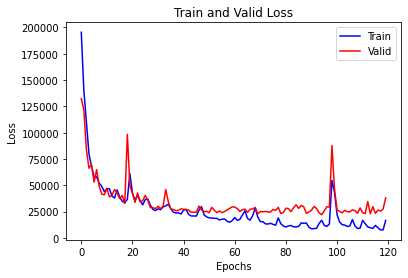

In [ ]:
plt.plot(train_loss_avg, 'b', label = 'Train')
plt.plot(valid_loss_avg, 'r', label = 'Valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Valid Loss')
plt.legend(loc="upper right")
plt.show()

# Evaluation

## Test Error

In [ ]:
# set to evaluation mode
test_loss_avg, num_batches = 0, 0
for test_images, test_labels in test_loader:
  with torch.no_grad():
    test_images = test_images.to(device)
    test_labels = test_labels.to(device)
    # vae reconstruction
    _, test_recon = ae_model(test_images)
    # reconstruction error
    loss = ae_loss(test_recon, test_labels)
    test_loss_avg += loss.item()
    num_batches += 1
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


average reconstruction error: 37488.470296


## Reconstruction Visualization

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


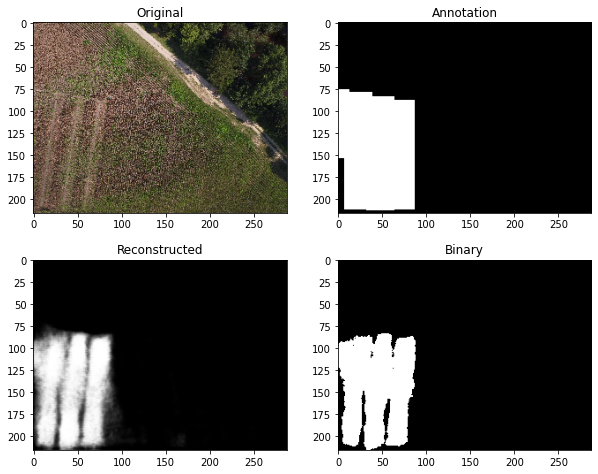

In [111]:
# Visualization Original and Reconstructed Images
images, labels = iter(test_loader).next()
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
img = images[0, :, :, :].permute(1, 2, 0)
axs[0, 0].imshow(img)
axs[0, 0].title.set_text('Original')
axs[0, 1].imshow(labels[0, 0, :, :], cmap = 'gray')
axs[0, 1].title.set_text('Annotation')
images = images.to(device)
images_ae = ae_model(images)
img_ae = images_ae[1][0, 0, :, :]
img_ae = img_ae.detach().cpu()
axs[1, 0].imshow(img_ae, cmap = 'gray')
axs[1, 0].title.set_text('Reconstructed')
img_bool = img_ae > 0.5
axs[1, 1].imshow(img_bool, cmap = 'gray')
axs[1, 1].title.set_text('Binary')



## Jaccard Index

In [ ]:
# CHECK FOR JACCARD

testX_tensor = testX_data.to(device) # move to GPU
#, testY_data
out,_ = ae_model(testX_tensor) # Forward in trained model
out.shape

In [ ]:
#fIX DIMEBSIONS
print(images_ae[0].shape, images.shape)
img_aef= F.interpolate(images_ae[0], size = images.shape[2:4])
print(img_aef.shape, images.shape)

In [ ]:
img_boolf = img_aef > 0.5
img_true = labels.flatten()
img_pred = img_boolf.flatten()
print(img_true.shape, img_pred.shape)

iou = jaccard_similarity_score(img_true.detach().cpu(), img_pred.detach().cpu(), normalize='binary')
print(iou)

## Dice Index

In [ ]:
intersection = np.logical_and(img_true.detach().cpu(),img_pred.detach().cpu())
dice = 2 * intersection.sum() / (img_true.sum() + img_pred.sum())
print(dice)

In [61]:
store_predictions = True
# Test Dataset
test_path = "/content/drive/My Drive/ECE_542-Project_2/Data/Test"
test_files = np.array(glob.glob(os.path.join(test_path, "*.jpg")))
test_files = sorted(test_files)

# Pytorch Dataset
test_dataset = Image_Dataset(test_files, test_files, transform = composed)

# Pytorch Dataloader
test_data_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = 2)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


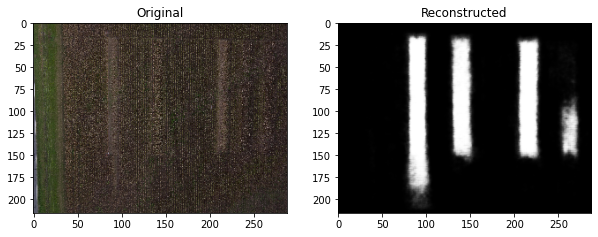

In [93]:
# Visualization Original and Reconstructed Images
images, labels = iter(test_data_loader).next()
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
img = images[0].permute(1, 2, 0)
axs[0].imshow(img)
axs[0].title.set_text('Original')
images = images.to(device)
images_ae = ae_model(images)
img_ae = images_ae[1][0, 0, :, :]
img_ae = img_ae.detach().cpu()
axs[1].imshow(img_ae, cmap = 'gray')
axs[1].title.set_text('Reconstructed')

## Storing Images

In [117]:
if store_predictions:
  # Predict Path
  predict_path = "/content/drive/My Drive/ECE_542-Project_2/Predict_segnet/"
  # Pytorch Dataloader
  test_data_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = 2)
  # Plot Images
  c = 0
  for test_images,_ in test_data_loader:
    # Forward in AE
    with torch.no_grad():
      test_images = test_images.to(device)
      _, recon_images = ae_model(test_images)
      recon_images = recon_images.detach().cpu()
      # mask_images = torch.argmax(recon_images, dim = 1)
      mask_images = recon_images[:][0, 0, :, :]
      # Upsample Image and store in predict path
      for i in range(len(mask_images)):
        mask_img = mask_images[i]
        # mask_img = torch.unsqueeze(torch.unsqueeze(mask_img, dim = 0), dim = 0).float()
        # mask_img = F.interpolate(mask_img, size = real_size)
        mask_name = test_files[i + batch_size * c][-8:][:4] + ".png"
        save_image(mask_img, predict_path + mask_name)
      c += 1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


IndexError: ignored